# Time series analysis with pandas

This is published as a Coding Club tutorial: https://ourcodingclub.github.io/2019/01/07/pandas-time-series.html

##### Overview
- Loading time series into pandas
- Working with datetime indexes
- Plotting time series
- Rolling calculations and resampling time series
- Reindexing and stacking signals

##### References
- pandas (see lots more in here):
  - https://pandas.pydata.org/pandas-docs/stable/visualization.html
- Time series:
    - https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial
    - https://otexts.org/fpp2
- [Misc. other stuff](https://gist.github.com/smithara/1e4724481383930ed431f0301d517e6a)

- Solar, heliospheric, and geomagnetic resources:
    - [Space weather info](https://www.swpc.noaa.gov/phenomena)
    - [Geomagnetic activity now](http://geomag.bgs.ac.uk/data_service/space_weather/Global_activity_now.html)
    - [Helioviewer at 2003 "Halloween" storms](https://helioviewer.org/?date=2003-10-28T11:16:19.000Z&imageScale=9.68176352&centerX=-19.36352704&centerY=19.36352704&imageLayers=%5BSOHO,LASCO,C2,white-light,1,50,0,60,1,2012-07-22T13:01:19.000Z%5D,%5BSOHO,EIT,304,1,100,0,60,1,2003-10-31T03:01:19.000Z%5D,%5BSOHO,MDI,magnetogram,1,0,0,60,1,2003-10-30T21:01:19.000Z%5D&eventLayers=%5BCE,all,1%5D&eventLabels=true) (click "Data Sources" on the left, and step through time in 5-min jumps to see a big CME; look at the MDI instrument to see [sunspots](https://en.wikipedia.org/wiki/Sunspot))
    - [Description of Dst index](http://roma2.rm.ingv.it/en/themes/23/geomagnetic_indices/27/dst_index)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Get F10.7, Dst, R, etc. from omni web

What is F10.7? https://www.swpc.noaa.gov/phenomena/f107-cm-radio-emissions

Data source info:
- https://omniweb.gsfc.nasa.gov/html/ow_data.html#3
- ftp://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/omni2.text

In [2]:
!wget ftp://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/omni2_all_years.dat

--2019-03-25 15:21:05--  ftp://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/omni2_all_years.dat
           => ‘omni2_all_years.dat.1’
Resolving spdf.gsfc.nasa.gov (spdf.gsfc.nasa.gov)... 169.154.154.63, 2001:4d0:2418:121::63
Connecting to spdf.gsfc.nasa.gov (spdf.gsfc.nasa.gov)|169.154.154.63|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/data/omni/low_res_omni ... done.
==> SIZE omni2_all_years.dat ... 163887168
==> PASV ... done.    ==> RETR omni2_all_years.dat ... done.
Length: 163887168 (156M) (unauthoritative)

100%[======================================>] 163,887,168 33.2MB/s   in 9.3s   

2019-03-25 15:21:17 (16.9 MB/s) - ‘omni2_all_years.dat.1’ saved [163887168]



- Create a dataframe from a csv
- Create a datetime index
- Drop unneeded columns and replace missing data with NaN

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [3]:
with open("omni2_all_years.dat") as f:
    print(f.readline())

1963   1  0 1771 99 99 999 999 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 999.9 9999999. 999.9 9999. 999.9 999.9 9.999 99.99 9999999. 999.9 9999. 999.9 999.9 9.999 999.99 999.99 999.9  7  33    -6  119 999999.99 99999.99 99999.99 99999.99 99999.99 99999.99  0   3 999.9 999.9 99999 99999 99.9



In [4]:
df = pd.read_csv("omni2_all_years.dat",
                 delim_whitespace=True,
                 usecols=[0, 1, 2, 8, 38, 39, 40, 50],
                 names=["Year", "DOY", "Hour", "IMF", "KP", "R", "Dst", "F10.7"])
df.head()

,Year,DOY,Hour,IMF,KP,R,Dst,F10.7
0,1963,1,0,999.9,7,33,-6,999.9
1,1963,1,1,999.9,7,33,-5,999.9
2,1963,1,2,999.9,7,33,-5,999.9
3,1963,1,3,999.9,20,33,-3,999.9
4,1963,1,4,999.9,20,33,-3,999.9


## 2. Sanitising and changing to a datetime index

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html

In [5]:
df.index = pd.to_datetime(df["Year"] * 100000 + df["DOY"] * 100 + df["Hour"], format='%Y%j%H')
df = df.drop(columns=["Year", "DOY", "Hour"])

# df.where(df["F10.7"]==999.9)
df = df.replace({"IMF":999.9,
                 "KP":99,
                 "R":999,
                 "Dst":99999,
                 "F10.7":999.9}, np.nan)
# df = df.replace(999.9, np.nan)
df.head()

,IMF,KP,R,Dst,F10.7
1963-01-01 00:00:00,NaN,7.0,33.0,-6.0,NaN
1963-01-01 01:00:00,NaN,7.0,33.0,-5.0,NaN
1963-01-01 02:00:00,NaN,7.0,33.0,-5.0,NaN
1963-01-01 03:00:00,NaN,20.0,33.0,-3.0,NaN
1963-01-01 04:00:00,NaN,20.0,33.0,-3.0,NaN


In [6]:
print("Dataframe shape: ", df.shape)
dt = (df.index[-1] - df.index[0])
print("Number of hours between start and end dates: ", dt.total_seconds()/3600 + 1)

h, d, y = 24, 365, 55
print(f"{h} hours/day * {d} days/year * {y} years = {h*d*y} hours")
print("{} hours/day * {} days/year * {} years = {} hours".format(h, d , y, h*d*y))
print("%d hours/day * %d days/year * %d years = %d hours"%(h, d , y, h*d*y))

Dataframe shape:  (499656, 5)
Number of hours between start and end dates:  499656.0
24 hours/day * 365 days/year * 55 years = 481800 hours
24 hours/day * 365 days/year * 55 years = 481800 hours
24 hours/day * 365 days/year * 55 years = 481800 hours


### Alternative loading with fwf

In [7]:
pd.read_fwf("omni2_all_years.dat", names=None, nafilter=False).head()

,1963,1,0,1771,99,99.1,999,999.1,999.9,999.9.1,...,99999.99.2,99999.99.3,99999.99.4,0.1,3,999.9.21,999.9.22,99999,99999.1,99.9
0,1963,1,1,1771,99,99,999,999,999.9,999.9,...,99999.99,99999.99,99999.99,0,3,999.9,999.9,99999,99999,99.9
1,1963,1,2,1771,99,99,999,999,999.9,999.9,...,99999.99,99999.99,99999.99,0,3,999.9,999.9,99999,99999,99.9
2,1963,1,3,1771,99,99,999,999,999.9,999.9,...,99999.99,99999.99,99999.99,0,7,999.9,999.9,99999,99999,99.9
3,1963,1,4,1771,99,99,999,999,999.9,999.9,...,99999.99,99999.99,99999.99,0,7,999.9,999.9,99999,99999,99.9
4,1963,1,5,1771,99,99,999,999,999.9,999.9,...,99999.99,99999.99,99999.99,0,7,999.9,999.9,99999,99999,99.9


In [8]:
pd.read_fwf("omni2_all_years.dat", colspecs=[(0,4), (4,9), (9,12)]).head()

,1963,1,0
0,1963,1,1
1,1963,1,2
2,1963,1,3
3,1963,1,4
4,1963,1,5


## 3. Plotting data

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html

It is convenient to use `.plot()` where the type of plot you want is available, otherwise you have to go back to maptlotlib to build the plot manually (or use some other tool)

- Different ways to plot data from dataframes using the ``.plot()`` method
- First steps in assessing time series

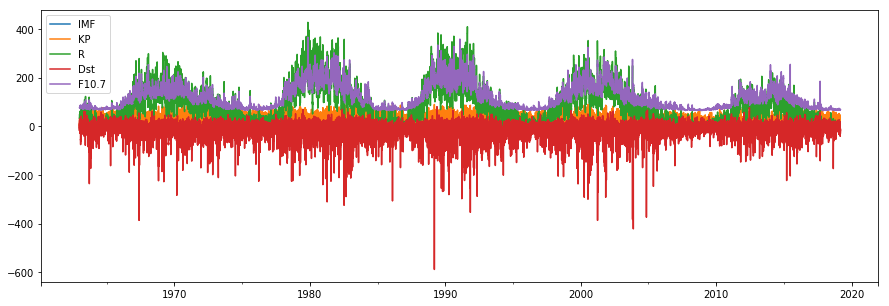

In [9]:
df.plot(figsize=(15,5));

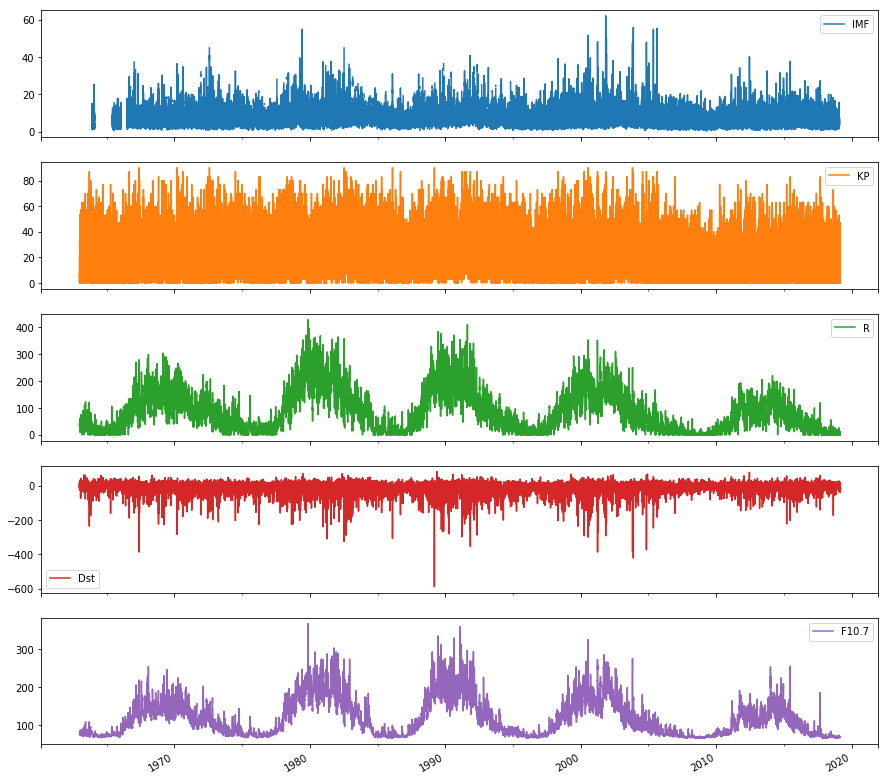

In [10]:
df.plot(subplots=True, figsize=(15,15));

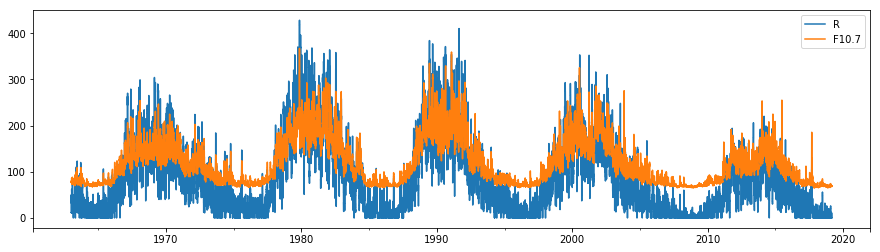

In [11]:
df.plot(y=["R", "F10.7"], figsize=(15,4));

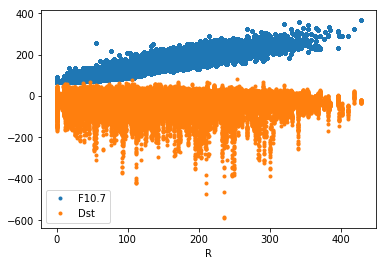

In [12]:
df.plot(x="R", y=["F10.7", "Dst"], style='.');

## 4. Resampling & rolling calculations & differencing

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html

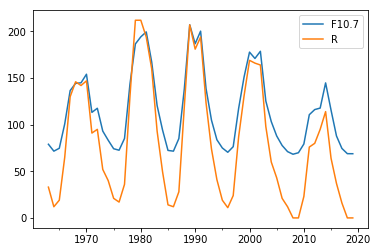

In [13]:
df[["F10.7", "R"]].resample("1y").median().plot();

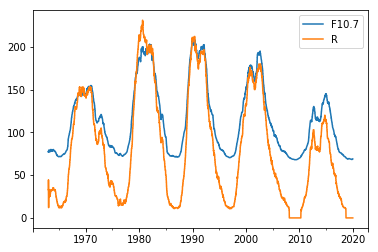

In [14]:
df[["F10.7", "R"]].rolling(24*365, min_periods=1).median().plot();

### Differencing

https://otexts.com/fpp2/stationarity.html

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html

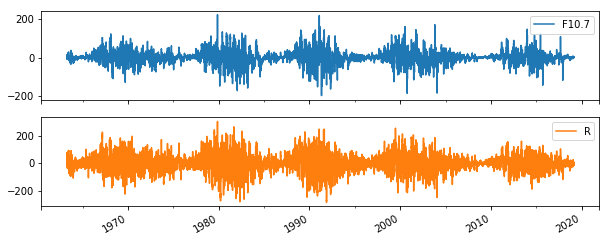

In [15]:
df[["F10.7", "R"]].diff(24*90).plot(subplots=True, figsize=(10,4));

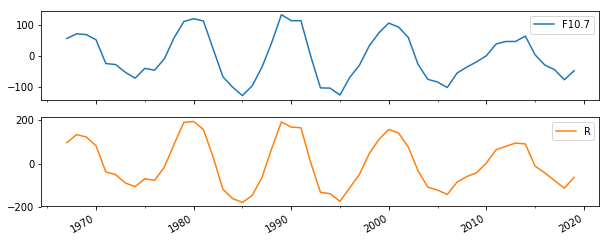

In [16]:
df[["F10.7", "R"]].resample("1y").median().diff(4).plot(subplots=True, figsize=(10,4));

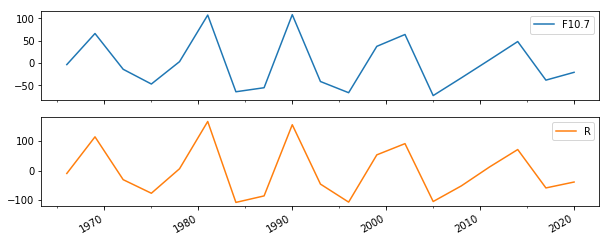

In [17]:
df[["F10.7", "R"]].resample("3y").median().diff().plot(subplots=True, figsize=(10,4));

Stack the operations (grouped by brackets), for more readable code

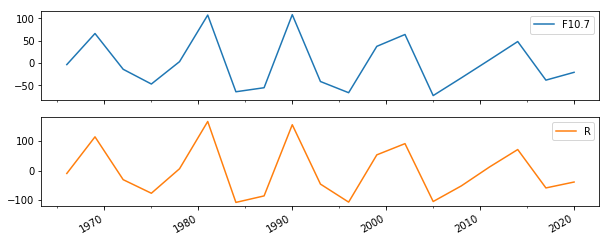

In [20]:
(
    df[["F10.7", "R"]]
    .resample("3y")
    .median()
    .diff()
    .plot(subplots=True, figsize=(10,4))
);

## 5. Identifying periodicity and correlation

### Autocorrelaton

https://pandas.pydata.org/pandas-docs/stable/visualization.html#autocorrelation-plot

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

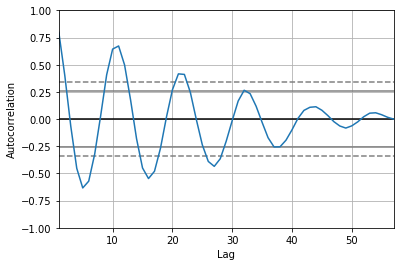

In [21]:
pd.plotting.autocorrelation_plot(df["R"].resample("1y").median());

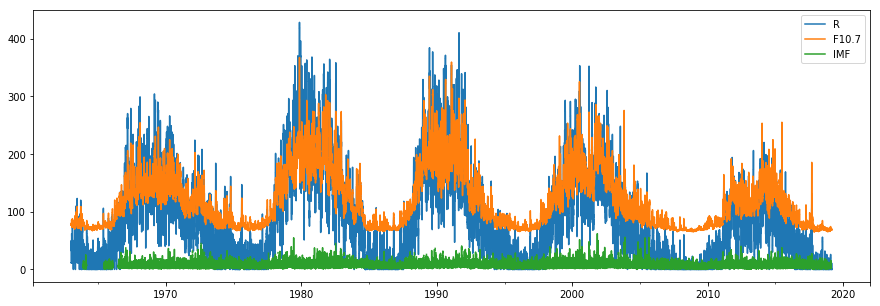

In [22]:
df.plot(y=["R", "F10.7", "IMF"], figsize=(15,5));

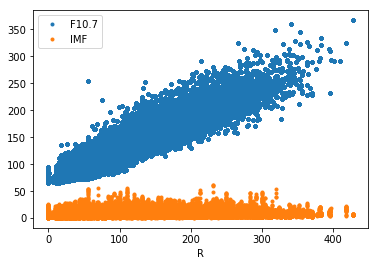

In [23]:
df.plot(x="R", y=["F10.7", "IMF"], style='.');

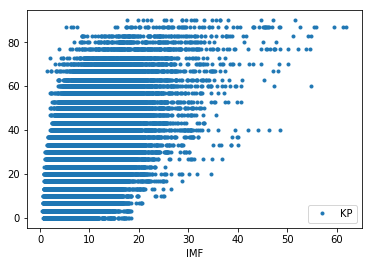

In [24]:
df.plot(x="IMF", y="KP", style='.');

### Counting occurrences

In [25]:
Dst_count = df["Dst"].where(df["Dst"]<-100).resample("1y").count()
Dst_count = Dst_count.reindex(df.index, method="bfill")
df["Dst_count"] = Dst_count

KP_count = df["KP"].where(df["KP"]>50).resample("1y").count()
KP_count = KP_count.reindex(df.index, method="bfill")
df["KP_count"] = KP_count

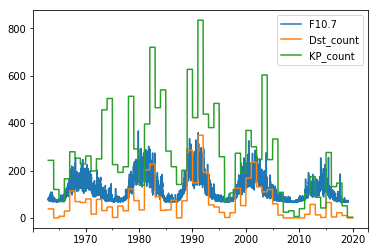

In [26]:
df.plot(y=["F10.7", "Dst_count", "KP_count"]);

In [27]:
df["KP_90day"] = df["KP"].rolling(24*90).median()
df["KP_1year"] = df["KP"].rolling(24*365).median()
df["KP_monthlymax"] = df["KP"].rolling(24*30).max()
df["KP_monthlymax_smoothed"] = df["KP_monthlymax"].rolling(24*365).median()
df.head()

,IMF,KP,R,Dst,F10.7,Dst_count,KP_count,KP_90day,KP_1year,KP_monthlymax,KP_monthlymax_smoothed
1963-01-01 00:00:00,NaN,7.0,33.0,-6.0,NaN,38.0,243.0,NaN,NaN,NaN,NaN
1963-01-01 01:00:00,NaN,7.0,33.0,-5.0,NaN,38.0,243.0,NaN,NaN,NaN,NaN
1963-01-01 02:00:00,NaN,7.0,33.0,-5.0,NaN,38.0,243.0,NaN,NaN,NaN,NaN
1963-01-01 03:00:00,NaN,20.0,33.0,-3.0,NaN,38.0,243.0,NaN,NaN,NaN,NaN
1963-01-01 04:00:00,NaN,20.0,33.0,-3.0,NaN,38.0,243.0,NaN,NaN,NaN,NaN


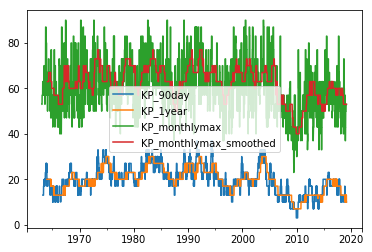

In [28]:
df.plot(y=["KP_90day", "KP_1year", "KP_monthlymax", "KP_monthlymax_smoothed"]);

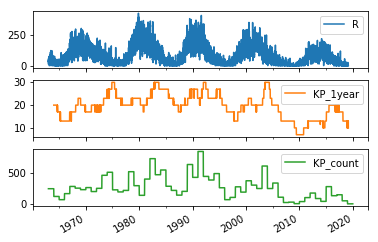

In [29]:
df.plot(y=["R", "KP_1year", "KP_count"], subplots=True);

https://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases

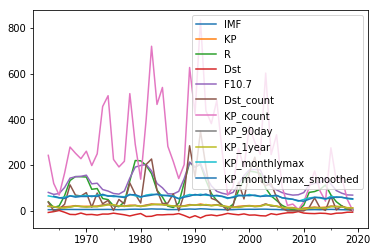

In [30]:
df.resample("1y").mean().plot();

## 6. Splitting and stacking cycles

In [31]:
# https://en.wikipedia.org/wiki/List_of_solar_cycles
minima = ["1964-10", "1976-03", "1986-09", "1996-08", "2008-12"]#, "2020"]
df_daily = df.resample("1D").mean()

In [32]:
df_daily[minima[-2]:minima[-1]]

,IMF,KP,R,Dst,F10.7,Dst_count,KP_count,KP_90day,KP_1year,KP_monthlymax,KP_monthlymax_smoothed
1996-08-01,5.337500,25.875,26.0,-15.000000,82.8,2.0,69.0,13.0,17.0,43.00,54.25
1996-08-02,4.395833,20.375,31.0,-14.875000,81.9,2.0,69.0,13.0,17.0,43.00,53.00
1996-08-03,4.679167,17.125,31.0,-10.541667,81.6,2.0,69.0,13.0,17.0,43.00,53.00
1996-08-04,4.695833,13.750,29.0,-8.291667,79.9,2.0,69.0,13.0,17.0,43.00,53.00
1996-08-05,4.695833,15.875,22.0,-11.458333,76.2,2.0,69.0,13.0,17.0,43.00,53.00
1996-08-06,4.595833,17.000,14.0,-7.166667,75.1,2.0,69.0,13.0,17.0,43.00,53.00
1996-08-07,4.654167,13.000,23.0,-7.083333,73.7,2.0,69.0,13.0,17.0,43.00,53.00
1996-08-08,7.333333,9.625,15.0,-5.166667,71.7,2.0,69.0,13.0,17.0,43.00,53.00
1996-08-09,7.275000,17.375,19.0,3.875000,72.1,2.0,69.0,13.0,17.0,43.00,53.00
1996-08-10,6.100000,10.625,20.0,-2.916667,73.6,2.0,69.0,13.0,17.0,43.00,53.00


In [33]:
def split_into_cycles(df):
    cycles = []
    # Split by solar cycle
    for start, end in zip(minima[0:-1], minima[1:]):
        cycle = df[start:end]
        # Convert from dates to days from minimum
        cycle.index = (cycle.index - cycle.index[0]).days
        # Extend so that each cycle lasts a full 5000 days (filled with nan)
        ix = pd.Int64Index(np.arange(0,5000))
        cycle.reindex(ix)
        cycles.append(cycle)
        
    return cycles

cycles = split_into_cycles(df_daily)

In [34]:
df.head()

,IMF,KP,R,Dst,F10.7,Dst_count,KP_count,KP_90day,KP_1year,KP_monthlymax,KP_monthlymax_smoothed
1963-01-01 00:00:00,NaN,7.0,33.0,-6.0,NaN,38.0,243.0,NaN,NaN,NaN,NaN
1963-01-01 01:00:00,NaN,7.0,33.0,-5.0,NaN,38.0,243.0,NaN,NaN,NaN,NaN
1963-01-01 02:00:00,NaN,7.0,33.0,-5.0,NaN,38.0,243.0,NaN,NaN,NaN,NaN
1963-01-01 03:00:00,NaN,20.0,33.0,-3.0,NaN,38.0,243.0,NaN,NaN,NaN,NaN
1963-01-01 04:00:00,NaN,20.0,33.0,-3.0,NaN,38.0,243.0,NaN,NaN,NaN,NaN


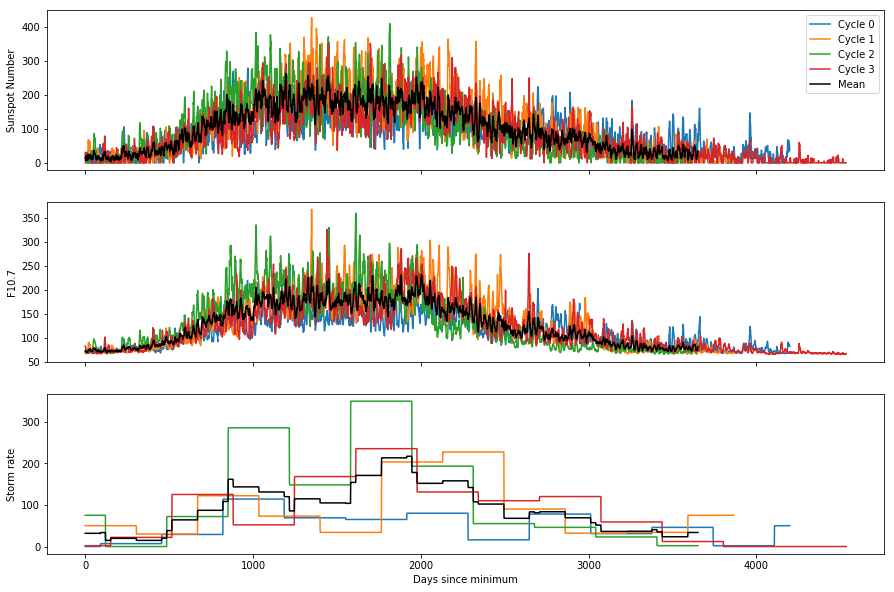

In [35]:
fig, axes = plt.subplots(3, 1, figsize=(15,10), sharex=True)
for i, cycle in enumerate(cycles):
    cycle["R"].plot(ax=axes[0], label=f"Cycle {i}")
    cycle["F10.7"].plot(ax=axes[1])
    cycle["Dst_count"].plot(ax=axes[2])
(sum(cycles)["R"]/4).plot(ax=axes[0], color="black", label="Mean")
(sum(cycles)["F10.7"]/4).plot(ax=axes[1], color="black")
(sum(cycles)["Dst_count"]/4).plot(ax=axes[2], color="black")
axes[0].legend()
axes[0].set_ylabel("Sunspot Number")
axes[1].set_ylabel("F10.7")
axes[2].set_ylabel("Storm rate")
axes[2].set_xlabel("Days since minimum");

## Exercises

- Beginner:
 - Load your own data into a pandas dataframe and do some basic data exploration and visualisation
- Advanced:
 - Rewrite the last part of this tutorial (`split_into_cycles` etc) using either a [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html) or [Group By](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html)